In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from data import ims, ims_noise
from model_global_dfn import GDFN
#from model_local_dfn import DFN, CombinedLoss
#from model_simple_local_dfn import DnCNN

gpu_ok = tf.test.is_gpu_available()
print("tf version:", tf.__version__)
print("use GPU:", gpu_ok)

57 images loading failed
tf version: 2.0.0
use GPU: True


In [2]:
# 避免显卡显存小而报错，显存自适应分配
physical_devices=tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)

# préparation des données

In [3]:
batch_size = 16

In [4]:
N_ims, h, w, color = ims.shape
ims = ims[:N_ims].astype(np.float32)
ims_noise = ims_noise[:N_ims].astype(np.float32)

In [5]:
# train test split
test_size = 0.1

train_X, train_Y = ims_noise, ims
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=test_size, random_state=42)

#train_X = train_X[:,np.newaxis,...]
#test_X = test_X[:,np.newaxis,...]

print('Training X: ', train_X.shape, train_X.dtype, train_X.max(), train_X.min())
print('Training Y: ', train_Y.shape, train_Y.dtype, train_Y.max(), train_Y.min())
print('Testing X: ', test_X.shape, test_X.dtype, test_X.max(), test_X.min())
print('Testing Y: ', test_Y.shape, test_Y.dtype, test_Y.max(), test_Y.min())

Training X:  (2513, 128, 128, 1) float32 1.0 0.0
Training Y:  (2513, 128, 128, 1) float32 1.0 0.0
Testing X:  (280, 128, 128, 1) float32 1.0 0.0
Testing Y:  (280, 128, 128, 1) float32 1.0 0.0


In [6]:
# Use tf.data API to shuffle and batch data.
train_dataset = tf.data.Dataset.from_tensor_slices((train_X,train_Y))
train_dataset = train_dataset.repeat().shuffle(5000).batch(batch_size).prefetch(1)

test_dataset = tf.data.Dataset.from_tensor_slices((test_X,test_Y))
test_dataset = test_dataset.batch(batch_size).prefetch(1)

In [7]:
color = False
blind_est = True
channel_att = False
spatial_att = False

# unet
core_bias = False

# gdfn
num_filters = 5

# kpn
burst_length = 1
kernel_size=[3]
sep_conv = False
core_bias = False

In [8]:
#model = KPN(color, burst_length, blind_est, kernel_size, sep_conv, 
                 #channel_att, spatial_att, core_bias)
#model = Unet(color, blind_est, channel_att, spatial_att, core_bias)
model = GDFN(color, num_filters, channel_att, spatial_att)


load_model = True
if load_model:
    model.load_weights(filepath="model_weights/global_dfn.ckpt")

# analyse des filtres dynamiques

In [9]:
color = 1 if color == False else 3

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [10]:
for test_X, test_Y in test_dataset.take(1):
    #pred_Y,core = model(test_X, test_X)
    pred_Y, core = model(test_X)

print(core.shape)

(16, 5, 5, 5)


## gdfn

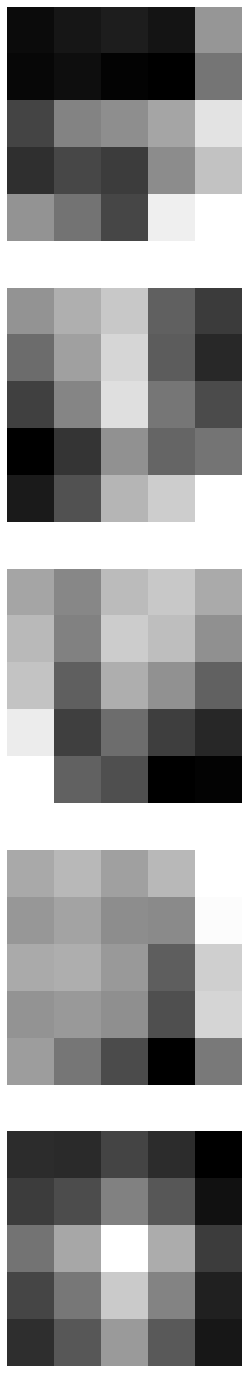

In [13]:
plt.figure(figsize = (15,5*num_filters))
for i in range(num_filters):
    cur_core = core[:,:,:,i*color**2:(i+1)*color**2]
    cur_core = tf.reduce_mean(cur_core, axis=0, keepdims=False)
    
    plt.subplot(num_filters,1,i+1)
    plt.imshow(cur_core.numpy().squeeze(), cmap='gray')
    plt.axis('off')
    
#plt.savefig('./eval/gdfn_'+current_time+'.png')
plt.show()